In [1]:
import datetime
import os
import random
from typing import Any, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import torch
import torch.nn as nn
from fastprogress import master_bar, progress_bar
from nptyping import NDArray
from pandas import DataFrame
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from src.pipelines import market_insight_preprocessing_pipeline as pipeline
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import keras

2022-03-28 15:23:48.211807: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-28 15:23:48.211852: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# raw_data = pipeline.market_insight_pipeline().run()
raw_data_small = pd.read_csv(
    "../datasets/interim/market_insight_preprocessed.csv",
    parse_dates=["date"],
)
raw_data_small.head()
raw_data_small.groupby("cat_id").count()

,date,product_id,root_cat_id,hits,clicks,popularity,cat_name
cat_id,,,,,,,
33,29,29,29,29,29,29,29
11037,399,399,399,399,399,399,399
11091,228,228,228,228,228,228,228
11573,902,902,902,902,902,902,902


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
use_cuda = torch.cuda.is_available()
device


'cuda'

In [4]:
# id11573 has mose data with 902 entries
# data_chosen_cat = raw_data.loc[raw_data["cat_id"] == 11573][["hits","clicks", "date"]]
data_chosen_cat_small= raw_data_small.loc[raw_data_small["cat_id"] == 11573][["hits", "date"]]
data_chosen_cat_filled_dates_small = data_chosen_cat_small.groupby(pd.Grouper(key="date", freq="D")).sum()

print(data_chosen_cat_filled_dates_small.head())
dates = data_chosen_cat_filled_dates_small.index.tolist()
print(dates[:2])
data_chosen_cat_filled_dates_small.tail()


            hits
date            
2018-12-02     2
2018-12-03    16
2018-12-04     1
2018-12-05     5
2018-12-06     3
[Timestamp('2018-12-02 00:00:00', freq='D'), Timestamp('2018-12-03 00:00:00', freq='D')]


,hits
date,
2021-09-04,3
2021-09-05,0
2021-09-06,4
2021-09-07,0
2021-09-08,1


In [5]:
# DATA BIG
raw_data = pd.read_csv('../datasets/raw/market_insights_overview_all_2022_02_14.csv', parse_dates=["date"])

# Filter away early 2018 data as it seems to contain errors
raw_data =raw_data .loc[raw_data ['date'] > '2018-12-01']

In [6]:
data_grouped = raw_data.groupby(['cat_id', "date"], as_index=False).count()
data_grouped["date"] = pd.to_datetime(data_grouped["date"])
data_grouped["interest"] = data_grouped["hits"] + data_grouped["clicks"]


data_chosen_categories = data_grouped[["interest", "date", "cat_id",]]
data_chosen_cat = data_grouped.loc[raw_data["cat_id"] == 2][["interest", "date"]]
data_chosen_cat_filled_dates = data_chosen_cat.groupby(pd.Grouper(key="date", freq="D")).sum()
print(data_chosen_cat_filled_dates.head())

            interest
date                
2018-12-02      1944
2018-12-03      3232
2018-12-04      2868
2018-12-05      2446
2018-12-06      1496


In [7]:
SEED = 1345


def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(SEED)


In [9]:
# Split into train data and validation data
#data = np.array(data_chosen_cat_filled_dates)
data = np.array(data_chosen_cat_filled_dates)
scaler = MinMaxScaler(feature_range=(0.1, 1))
data_normalized = scaler.fit_transform(data)
#test_size = 0.2
#data_validation = data_normalized[-int(test_size * len(data)) :]
#data_train = data_normalized[: -int(test_size * len(data))]
window_input_size = 10
window_output_size = 7
test_size = window_input_size + window_output_size
train_data_normalized = data_normalized[:len(data) -test_size ]
validation_data_normalized= data_normalized[len(data_normalized) - test_size:]
print(train_data_normalized.shape)
print(validation_data_normalized.shape) 

SyntaxError: invalid syntax (519516927.py, line 11)

In [ ]:


class TimeseriesDataset(Dataset):
    """
    Custom Dataset subclass.
    Serves as input to DataLoader to transform X
      into sequence data using rolling window.
    DataLoader using this dataset will output batches
      of `(batch_size, seq_len, n_features)` shape.
    Suitable as an input to RNNs.
    """

    def __init__(self, time_series: np.ndarray, seq_len: int, y_size: int):
        self.time_series = torch.tensor(time_series).float()
        self.seq_len = seq_len
        self.y_size = y_size

    def __len__(self):
        return self.time_series.__len__() - (self.seq_len + self.y_size - 1)
        #return self.time_series.__len__() - 1

    def __getitem__(self, index):
        # return x, y
        return (
            self.time_series[index : index + self.seq_len],
            self.time_series[index + self.seq_len : index + self.seq_len + self.y_size],
        )


# Wait, is this a CPU tensor now? Why? Where is .to(device)?

#raw_data = pd.read_csv("../datasets/external/Alcohol_Sales.csv.csv", parse_dates=["DATE"])
train_data = TimeseriesDataset(train_data_normalized, seq_len=window_input_size, y_size=window_output_size)
val_data = TimeseriesDataset(validation_data_normalized, seq_len=window_input_size, y_size=window_output_size)
print(val_data.__len__())

1


In [ ]:
batch_size = 39
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=False, drop_last=True)
train_loader_no_batch = DataLoader(dataset=train_data, batch_size=1, shuffle=False, drop_last=True)
val_loader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=False, drop_last=False)
val_loader_no_batch = DataLoader(dataset=val_data, batch_size=1, shuffle=False, drop_last=False)
print("train x shape", next(iter(train_loader))[0].shape)
print("train y shape", next(iter(train_loader))[1].shape)
print("val x shape", next(iter(val_loader))[0].shape)

train x shape torch.Size([39, 10, 1])
train y shape torch.Size([39, 7, 1])
val x shape torch.Size([1, 10, 1])


In [ ]:
class LSTMPytorch(nn.Module):
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        output_size: int,
        num_layers: int,
        learning_rate: float,
        batch_first: bool = True,
        dropout: float = 0.2,
        bidirectional: bool = False,
        optimizer_name: str = "Adam",
        batch_size: int = 1,
    ):
        super(LSTMPytorch, self).__init__()
        self.output_size = output_size  # shape of output
        self.num_layers = num_layers  # number of layers
        self.input_size = input_size  # number of features in each sample
        self.hidden_size = hidden_size  # hidden state
        self.learning_rate = learning_rate  # learning rate
        self.dropout = nn.Dropout(p=dropout)
        self.batch_size = batch_size

        self.criterion = torch.nn.MSELoss()

        self.lstm = nn.LSTM(
            input_size=self.input_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            batch_first=True,
        )
        self.fully_conencted_layer = nn.Linear(
            in_features=self.hidden_size, out_features=self.output_size * self.input_size
        )

        parameters = list(self.lstm.parameters()) + list(self.fully_conencted_layer.parameters())
        print(self.lstm.parameters() == parameters)

        if torch.cuda.is_available():
            self.cuda()
            self.criterion.cuda()

        # self.optimizer = torch.optim.Adam(parameters, lr=self.learning_rate,weight_decay=1e-5)
        self.optimizer = getattr(torch.optim, optimizer_name)(self.parameters(), lr=learning_rate)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, patience=500, factor=0.5, min_lr=1e-7, eps=1e-08
        )
        self.reset_hidden_state(batch_size=batch_size)

    def reset_hidden_state(self, batch_size):
        self.h_0 = Variable(torch.zeros(self.num_layers, batch_size, self.hidden_size, device="cuda:0"))

        self.c_0 = Variable(torch.zeros(self.num_layers, batch_size, self.hidden_size, device="cuda:0"))

    def forward(self, x):
        #self.reset_hidden_state(batch_size=x.size(0), x=x)
        # Here you have defined the hidden state, and internal state first, initialized with zeros.

        # Propagate input through LSTM

        # output (seq_len, batch, hidden_size * num_directions): tensor containing the output features (h_t) from the last layer of the RNN, for each t.
        # h_n (num_layers * num_directions, batch, hidden_size): tensor containing the hidden state for t=seq_len
        # c_n (num_layers * num_directions, batch, hidden_size): tensor containing the cell state for t=seq_len
        ula, (h_out, _) = self.lstm(x, (self.h_0, self.c_0))
        # print("output", ula.shape)
        # Choose the hidden state from the last layer
        last_hidden_state_layer = h_out[-1]
        # h_out = h_out.view(-1, self.hidden_size)
        # out_squashed = ula.view(-1, self.hidden_size)

        out = self.fully_conencted_layer(last_hidden_state_layer)
        # out = self.fc(ula)
        out = self.dropout(out)

        out_multi_feature = out.reshape(out.size(0), self.output_size, self.input_size)
        # return out
        return out_multi_feature

    # Builds function that performs a step in the train loop
    def train_step(self, x, y):
        # Sets model to TRAIN mode
        self.train()
        # Makes predictions
        yhat = self(x)
        # print("yhat", yhat.shape)
        # Computes loss
        loss = self.criterion(y, yhat)

        # Computes gradients
        loss.backward()
        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()
        # Returns the loss
        return loss.item()

    def validation_step(self, x, y):
        val_losses = []
        with torch.no_grad():
            self.eval()

            yhat = self(x)
            val_loss = self.criterion(y, yhat)
            val_losses.append(val_loss.item())

        return val_losses

    def train_network(
        self,
        train_loader,
        val_loader,
        n_epochs=100,
        verbose=True,
        optuna_trial: optuna.Trial = None,
    ):
        self.train()
        losses = []
        val_losses = []
        for epoch in progress_bar(range(n_epochs)):
            for x_batch, y_batch in train_loader:
                # the dataset "lives" in the CPU, so do our mini-batches
                # therefore, we need to send those mini-batches to the
                # device where the model "lives"
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                loss = self.train_step(x_batch, y_batch)
                losses.append(loss)

            for x_val, y_val in val_loader:
                x_val = x_val.to(device)
                y_val = y_val.to(device)

                val_loss = self.validation_step(x_val, y_val)
                val_losses.append(val_loss)

            if optuna_trial:
                accuracy = self.calculate_mean_score(val_losses)
                optuna_trial.report(accuracy, epoch)

                if optuna_trial.should_prune():
                    print("Pruning trial!")
                    raise optuna.exceptions.TrialPruned()

            if epoch % 50 == 0:
                print(f"Epoch: {epoch}, loss: {loss}. Validation losses: {val_loss}")
        return losses, val_losses

    def calculate_mean_score(self, losses: List[torch.Tensor]) -> float:
        return np.mean(losses)



In [ ]:
# Train network
lstm = LSTMPytorch(
    input_size=1,
    hidden_size=50,
    output_size=window_output_size,
    num_layers=2,
    learning_rate=0.001,
    batch_size=batch_size,
)
print(lstm)
losses, val_losses = lstm.train_network(train_loader, val_loader, n_epochs=100, verbose=True)


False
LSTMPytorch(
  (dropout): Dropout(p=0.2, inplace=False)
  (criterion): MSELoss()
  (lstm): LSTM(1, 50, num_layers=2, batch_first=True)
  (fully_conencted_layer): Linear(in_features=50, out_features=7, bias=True)
)


RuntimeError: Expected hidden[0] size (2, 1, 50), got [2, 39, 50]

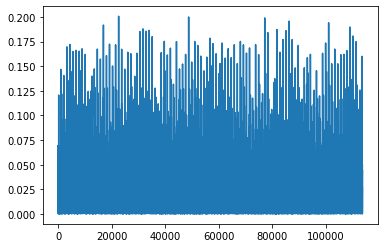

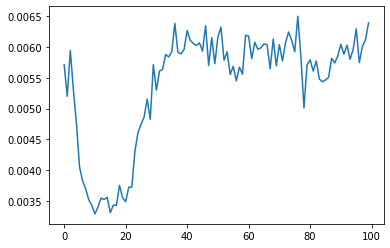

In [ ]:
plt.plot(losses)
plt.show()
val_losses_flat = [item for sublist in val_losses for item in sublist]
plt.plot(val_losses_flat)

In [ ]:
(lstm.calculate_mean_score(val_losses))

0.007761603915831074

torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size

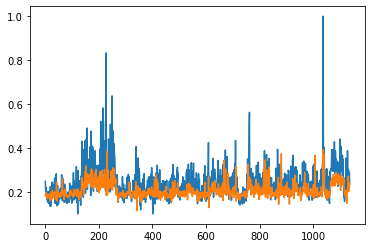

correct values (1, 7)
train losses 0.01626884182758361
val losses 0.005377984994556755


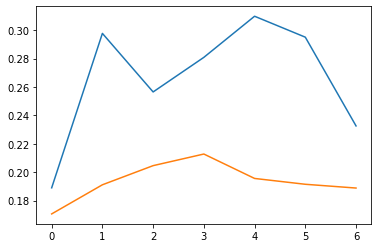

In [ ]:
# Predict training
correct_values = []
predictions = []
for x_batch, y_batch in train_loader:
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    yhat = lstm(x_batch)
    print(yhat.shape)

    predictions.extend(yhat[:, 0, 0].detach().cpu().numpy())
    correct_values.extend(y_batch[:, 0, 0].detach().cpu().numpy())
    # correct_values.append(y_batch.cpu().detach().numpy().flatten())
    # predictions.append(yhat.detach().cpu().numpy().flatten())
predictions = np.array(predictions)
correct_values = np.array(correct_values)
plt.plot(correct_values.flatten())
plt.plot(predictions.flatten() )

plt.show()

# Predict validation
correct_values_val = []
predictions_val = []
for x_batch, y_batch in val_loader:
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    yhat = lstm(x_batch)

    predictions_val.extend(yhat[::7, :, 0].detach().cpu().numpy())
    correct_values_val.extend(y_batch[::7, :, 0].detach().cpu().numpy())
    # correct_values.append(y_batch.cpu().detach().numpy().flatten())
    # predictions.append(yhat.detach().cpu().numpy().flatten())
predictions_val = np.array(predictions_val)
correct_values_val = np.array(correct_values_val)
print("correct values", correct_values_val.shape)
plt.plot(correct_values_val.flatten())
plt.plot(predictions_val.flatten() )
print("train losses", sum(losses)/len(losses))
print("val losses", sum(val_losses_flat)/len(val_losses_flat))

In [ ]:
x_train = []
y_train = []
x_val = []
y_val = []
for batch in train_loader:
  x, y = batch
  x_train.extend((x.cpu().detach().numpy()))
  y_train.extend((y.cpu().detach().numpy()))
for batch in val_loader_no_batch:
  x, y = batch
  x_val.extend((x.cpu().detach().numpy()))
  y_val.extend((y.cpu().detach().numpy()))
print(x_train[:1])
print(np.array(x_val[:1]))
print(x_train[0].shape)
print(x_val[0].shape)

[array([[0.20384616],
       [0.2726496 ],
       [0.25320512],
       [0.23066239],
       [0.17991453],
       [0.191453  ],
       [0.20747863],
       [0.25587606],
       [0.21923077],
       [0.16239317]], dtype=float32)]
[[[0.23418804]
  [0.21047008]
  [0.2568376 ]
  [0.23760684]
  [0.24754274]
  [0.21677351]
  [0.27136752]
  [0.24380341]
  [0.12745726]
  [0.19722222]]]
(10, 1)
(10, 1)


In [ ]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("X_val", x_val.shape)
print("y_val", y_val.shape)


x_train (1131, 10, 1)
y_train (1131, 7, 1)
X_val (1, 10, 1)
y_val (1, 7, 1)


In [ ]:
regressor = Sequential()
print((batch_size, x_train[0].shape[0], 1))
regressor.add(LSTM(stateful=True, batch_input_shape=(batch_size, x_train[0].shape[0], 1), units = 50, return_sequences = False,))
#regressor.add(LSTM(stateful=False, units = 50, return_sequences = True, input_shape=(x_train[0].shape[1], 1)))

regressor.add(Dropout(0.20))

regressor.add(Dense(units = window_output_size))
opt = keras.optimizer_v2.adam.Adam(learning_rate=0.001)
regressor.compile(optimizer = opt, loss = 'mean_squared_error',)
print(regressor.summary())


(39, 10, 1)
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (39, 50)                  10400     
                                                                 
 dropout_11 (Dropout)        (39, 50)                  0         
                                                                 
 dense_11 (Dense)            (39, 7)                   357       
                                                                 
Total params: 10,757
Trainable params: 10,757
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:

regressor.fit(x_train, y_train, epochs = 100, batch_size = batch_size)

Epoch 1/100
29/29 [==============================] - 1s 4ms/step - loss: 0.0342
Epoch 2/100
29/29 [==============================] - 0s 4ms/step - loss: 0.0072
Epoch 3/100
29/29 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 4/100
29/29 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 5/100
29/29 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 6/100
29/29 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 7/100
29/29 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 8/100
29/29 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 9/100
29/29 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 10/100
29/29 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 11/100
29/29 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 12/100
29/29 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 13/100
29/29 [=================

In [ ]:

print(regressor.summary())
print("Training loss", regressor.evaluate(x_train, y_train, batch_size=batch_size))

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (39, 50)                  10400     
                                                                 
 dropout_11 (Dropout)        (39, 50)                  0         
                                                                 
 dense_11 (Dense)            (39, 7)                   357       
                                                                 
Total params: 10,757
Trainable params: 10,757
Non-trainable params: 0
_________________________________________________________________
None
29/29 [==============================] - 0s 2ms/step - loss: 0.0039
Training loss 0.003942121751606464


In [ ]:

regressor_predictor = Sequential()
print((batch_size, x_train[0].shape[0], 1))
regressor_predictor.add(LSTM(stateful=True, batch_input_shape=(1, x_train[0].shape[0], 1), units = 50, return_sequences = False,))
#regressor_predictor.add(LSTM(stateful=False, units = 50, return_sequences = True, input_shape=(x_train[0].shape[1], 1)))
regressor_predictor.add(Dropout(0.20))
regressor_predictor.add(Dense(units = window_output_size))
opt = keras.optimizer_v2.adam.Adam(learning_rate=0.001)
regressor_predictor.compile(optimizer = opt, loss = 'mean_squared_error',)
trained_weights = regressor.get_weights()
regressor_predictor.set_weights(trained_weights)

(39, 10, 1)


In [ ]:
print(x_val.shape)
print(y_val.shape)

(1, 10, 1)
(1, 7, 1)
(1131, 10, 1)
(1131, 7, 1)


1/1 [==============================] - 0s 12ms/step - loss: 0.0033
validation loss 0.003281449666246772
mean_squared_error
y_pred (1131, 7)


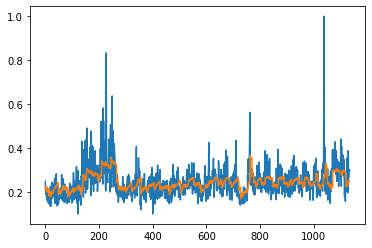

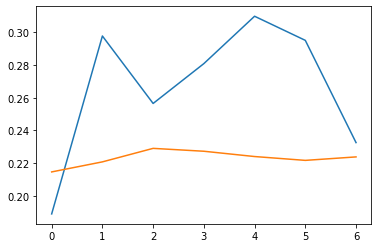

In [ ]:
print("validation loss", regressor_predictor.evaluate(x_val, y_val, batch_size=1))
print(regressor_predictor.loss)
y_pred = regressor_predictor.predict(x_train, batch_size=1)
y_pred_val = regressor_predictor.predict(x_val, batch_size=1)
print("y_pred", y_pred.shape)
plt.plot(y_train[::window_output_size, :, 0].flatten())
plt.plot(y_pred[::window_output_size, :].flatten())
plt.show()
plt.plot(y_val[::window_input_size, :, 0].flatten())
plt.plot(y_pred_val[::window_input_size, :].flatten())